# 압력 Heatmap 생성 파이프라인 Notebook (v02)

이 노트북은 두 가지 종류의 발바닥 이미지를 압력 Heatmap으로 변환하는 파이프라인입니다.

1. **Jet 컬러맵 이미지**: Jet 컬러맵으로 압력이 표현된 이미지를 0~255 범위의 압력 값으로 복원하고 시각화합니다.
2. **일반 RGB 이미지 (웹캠 등)**: 컬러맵을 알 수 없는 일반 RGB 이미지를 0~255 범위의 '상대 압력'으로 변환하고 시각화합니다.

### `pressure_heatmap_pipeline_02.ipynb` 코드 흐름 정리

이 노트북은 Jet 컬러맵으로 색칠된 Footprint 이미지지를 입력으로 받아,
이를 **0~255 압력 값으로 복원**하고, 시각화하기 좋게 가공한 뒤
**Raw / Equalized 두 가지 heatmap**으로 보여주는 파이프라인입니다.

**개선 사항 (v02):**
1. **메모리 최적화**: `jet_to_intensity` 함수에서 대용량 이미지 처리 시 메모리 부족(OOM)을 방지하기 위해 배치(Batch) 처리를 도입했습니다.
2. **노이즈 제거**: 배경 마스크 생성 시 모폴로지 연산(Opening/Closing)을 추가하여 노이즈를 줄이고 마스크 품질을 높였습니다.
3. **시각화 개선**: 단순 히스토그램 평활화 대신 **CLAHE (Contrast Limited Adaptive Histogram Equalization)**를 적용하여 국소적인 디테일을 더 잘 보존하도록 했습니다.

---

#### 1-A. Jet 컬러맵 이미지 → 압력 값 복원

- `get_jet_lut()`
  - matplotlib의 `'jet'` 컬러맵에서 **0~255 단계의 색상 LUT**(RGB 테이블)를 만듭니다.
- `jet_to_intensity(rgb)`
  - 입력 RGB 이미지의 각 픽셀 색을 LUT와 비교해서  
    **가장 가까운 색의 인덱스(0~255)**를 찾고, 이를 **압력 intensity 값**으로 사용합니다.
  - **[개선]** 픽셀을 청크 단위로 나누어 처리하여 메모리 사용량을 일정하게 유지합니다.

---

#### 1-B. 일반 RGB 이미지 → 상대 압력 값 변환

- `rgb_to_relative_pressure(rgb)`
  - 웹캠 이미지처럼 컬러맵을 알 수 없는 경우 사용합니다.
  - 이미지를 **Grayscale로 변환**하여 밝기 값을 **상대적인 압력 강도**로 간주합니다.
  - `get_background_mask`를 이용해 배경을 제거합니다.

#### 2. 공통 유틸리티: 배경 제거 및 시각화

- `get_background_mask(rgb, thr=10)`
  - 이미지를 Grayscale로 바꾼 뒤, **밝기 `thr` 이하인 어두운 영역을 배경**으로 간주합니다.
  - **[개선]** 모폴로지 연산을 통해 미세한 노이즈를 제거하고 구멍을 메웁니다.
- `make_pressure_map(img)`
  - Jet 컬러 이미지를 `jet_to_intensity`로 압력 맵으로 만든 후,
  - `get_background_mask`로 얻은 배경 위치의 값은 **0으로 만들어**  
    **발바닥 부분만 남긴 압력 맵**을 만듭니다.

- `equalize_for_visualization(pmap)`
  - **[개선]** OpenCV의 `equalizeHist` 대신 **CLAHE**를 사용하여 과도한 대비 증폭을 막고 자연스러운 결과를 만듭니다.
  - 배경(값 0)은 따로 처리하여 **평활화 과정에서 배경이 밝아지지 않도록** 유지합니다.

---

#### 4. Heatmap 시각화

- `plot_heatmap(pmap, title="Heatmap")`
  - 입력 압력 맵을 **Jet 컬러맵으로 다시 칠해서** heatmap으로 표시합니다.
  - 축/눈금은 제거하고, **colorbar**로 압력 강도 범위를 함께 보여 줍니다.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ============================================
# 유틸리티 함수 모음
# 1. Jet 컬러맵 이미지 -> 압력 값 복원 관련
# 2. 일반 RGB 이미지 -> 상대 압력 변환 관련
# 3. 공통 유틸리티 (배경제거, 시각화)
# ============================================

# --- Jet LUT 생성: 0~255 인덱스를 Jet RGB 색상에 매핑 ---
def get_jet_lut():
    # matplotlib의 'jet' 컬러맵에서 256개의 색을 뽑아 RGB LUT로 저장
    cmap = plt.get_cmap('jet', 256)
    return (cmap(np.linspace(0, 1, 256))[:, :3] * 255).astype(np.float32)


JET_LUT = get_jet_lut()


# --- Jet 역변환: 색이 입혀진 RGB -> 0~255 단일 채널 intensity ---
def jet_to_intensity(rgb):
    h, w, _ = rgb.shape
    # (H, W, 3) 이미지를 (N, 3) 형태로 펼치기
    flat = rgb.reshape(-1, 3).astype(np.float32)
    
    # [개선] 메모리 부족 방지를 위해 청크 단위로 처리
    chunk_size = 10000  # 한 번에 처리할 픽셀 수
    n_pixels = flat.shape[0]
    intensity = np.zeros(n_pixels, dtype=np.float32)
    
    for i in range(0, n_pixels, chunk_size):
        end = min(i + chunk_size, n_pixels)
        batch = flat[i:end]
        
        # 각 픽셀과 LUT(256개 색상)의 거리(제곱 오차)를 계산
        # Broadcasting: (B, 1, 3) - (1, 256, 3) -> (B, 256, 3)
        diff = np.sum((batch[:, None, :] - JET_LUT[None, :, :]) ** 2, axis=2)
        
        # 가장 가까운 LUT 인덱스를 intensity 값(0~255)으로 사용
        intensity[i:end] = np.argmin(diff, axis=1)
    
    return intensity.reshape(h, w)


# --- 배경 마스크: 거의 검은 영역을 배경으로 판단 ---
def get_background_mask(rgb, thr=10):
    # RGB 이미지를 Grayscale로 변환
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
    # [개선] 모폴로지 연산으로 노이즈 제거
    # 전경(Foreground) 마스크 생성
    fg = (gray >= thr).astype(np.uint8) * 255
    
    # 커널 크기는 이미지 해상도에 따라 조절 가능 (5x5는 일반적인 크기)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    # Opening: 작은 노이즈 제거
    fg = cv2.morphologyEx(fg, cv2.MORPH_OPEN, kernel)
    # Closing: 내부의 작은 구멍 메우기
    fg = cv2.morphologyEx(fg, cv2.MORPH_CLOSE, kernel)
    
    # 다시 배경(True) 마스크로 변환
    mask = fg == 0
    return mask


# --- [신규] 일반 RGB 이미지 -> 상대 압력 맵 변환 ---
def rgb_to_relative_pressure(rgb):
    # 웹캠 이미지 등 컬러맵을 알 수 없는 이미지를 Grayscale로 변환
    # 밝기(Luminance)를 상대적인 압력 강도로 간주
    relative_pressure_map = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
    # 배경 영역을 찾아 압력 값을 0으로 설정
    bg_mask = get_background_mask(rgb, thr=10)
    relative_pressure_map[bg_mask] = 0
    return relative_pressure_map.astype(np.float32)


# --- 압력 맵 생성: Jet 역변환 + 배경 제거 ---
def make_pressure_map(img):
    # Jet 컬러맵이 입혀진 이미지를 0~255 압력 값으로 변환
    base = jet_to_intensity(img)
    # 거의 검은 영역은 배경으로 처리
    bg = get_background_mask(img)
    # 배경 위치의 값은 0으로 강제
    base[bg] = 0
    return base


# --- 평탄화(시각화용): 압력 분포를 보기 좋게 만들기 ---
def equalize_for_visualization(pmap):
    # OpenCV 함수들은 uint8을 주로 사용하므로 변환
    p = pmap.astype(np.uint8)
    # 값이 0인 영역을 배경으로 간주
    bg = p == 0
    # 전경이 하나도 없으면(모두 배경) 그대로 반환
    if np.sum(~bg) == 0:
        return pmap
        
    # [개선] CLAHE (Contrast Limited Adaptive Histogram Equalization) 적용
    # clipLimit: 대비 제한 임계값 (높을수록 대비가 강해짐, 보통 2.0~4.0)
    # tileGridSize: 이미지를 나눌 그리드 크기 (8x8이 기본)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    # CLAHE 적용
    eq = clahe.apply(p)
    
    # 배경 위치는 다시 0으로 되돌림 (CLAHE 과정에서 밝아졌을 수 있음)
    eq[bg] = 0
    
    return eq.astype(np.float32)


# --- 시각화: 압력 맵 + 색상바 출력 ---
def plot_heatmap(pmap, title="Heatmap"):
    # 하나의 Figure 안에 이미지와 색상바를 함께 배치
    fig, ax = plt.subplots(figsize=(5, 10))
    # 0~255 압력 값을 Jet 컬러맵으로 표시
    im = ax.imshow(pmap, cmap="jet", vmin=0, vmax=255)
    ax.set_title(title)
    # 축 눈금/테두리는 숨김
    ax.axis("off")
    # 오른쪽에 색상바를 적당한 크기로 배치
    fig.colorbar(im, ax=ax, fraction=0.05, pad=0.02)
    # 전체 레이아웃(이미지 vs 색상바) 자동 정리
    plt.tight_layout()
    plt.show()


=== 파이프라인 1: Jet 컬러맵 이미지 처리 ===

--- Processing Image: test_foot_data/0_Original_Source.png_left_256.png ---


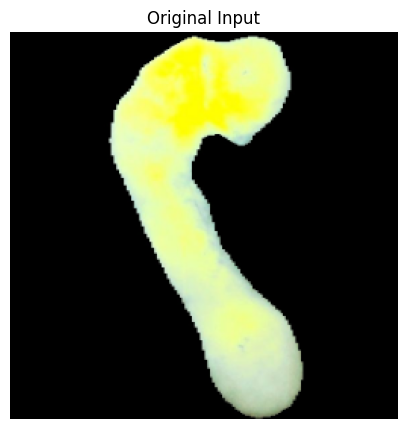

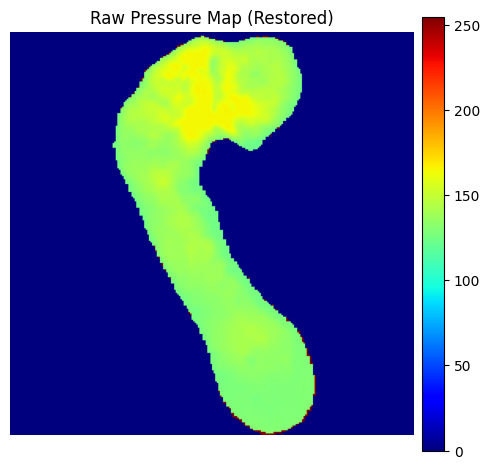

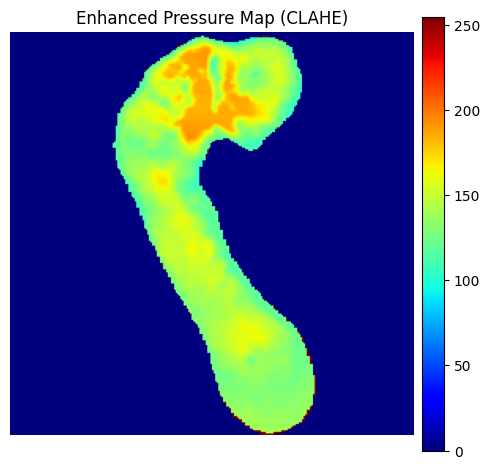


--- Processing Image: test_foot_data/0_Original_Source.png_right_256.png ---


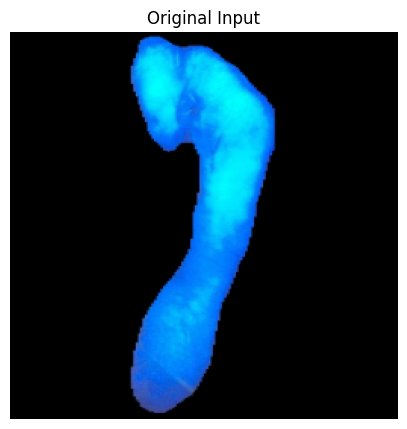

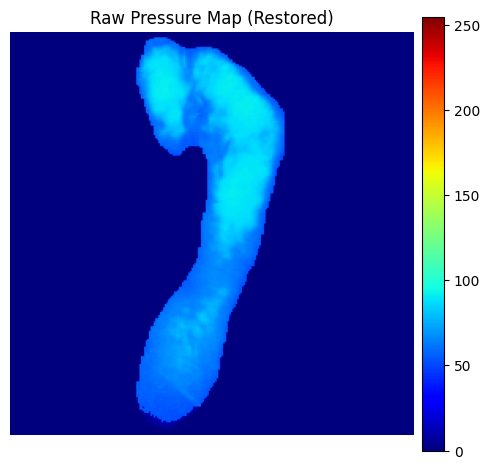

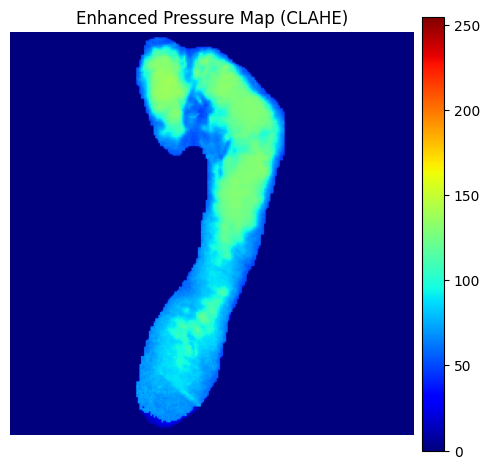

In [3]:
print("=== 파이프라인 1: Jet 컬러맵 이미지 처리 ===")

jet_img_paths = [
    "test_foot_data/0_Original_Source.png_left_256.png",
    "test_foot_data/0_Original_Source.png_right_256.png"
]

for img_path in jet_img_paths:
    print(f"\n--- Processing Image: {img_path} ---")
    img_bgr = cv2.imread(img_path)
    
    if img_bgr is not None:
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # 1. 원본 확인
        plt.figure(figsize=(5, 10))
        plt.imshow(img_rgb)
        plt.title(f"Original Input")
        plt.axis("off")
        plt.show()

        # 2. 압력 맵 생성
        pm = make_pressure_map(img_rgb)
        plot_heatmap(pm, f"Raw Pressure Map (Restored)")

        # 3. 시각화 개선 (CLAHE)
        pm_eq = equalize_for_visualization(pm)
        plot_heatmap(pm_eq, f"Enhanced Pressure Map (CLAHE)")
    else:
        print(f"이미지를 찾을 수 없습니다: {img_path}")



=== 파이프라인 2: 일반 RGB 이미지(웹캠) 처리 ===

--- Processing Image: test_foot_data/0_Original_Source.png_left_256.png ---


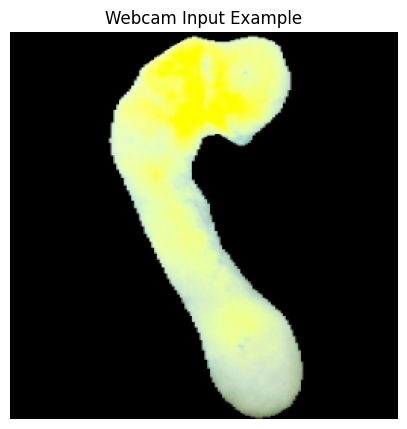

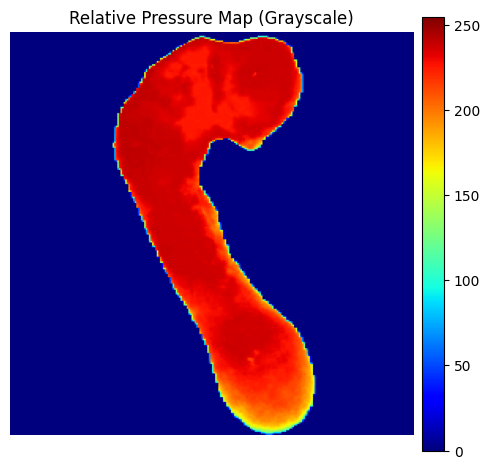

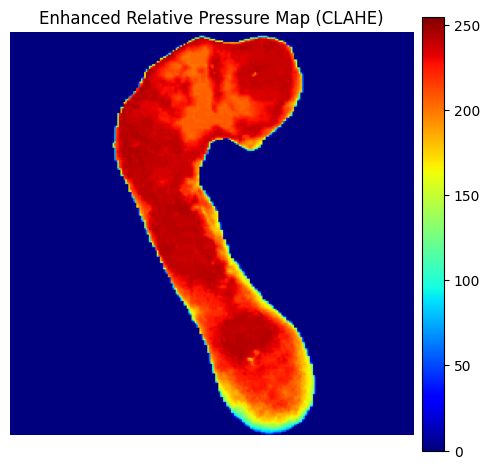

In [4]:
print("\n\n=== 파이프라인 2: 일반 RGB 이미지(웹캠) 처리 ===")

# 웹캠으로 캡처했다고 가정한 일반 RGB 이미지 (Jet 컬러맵 아님)
# 여기서는 테스트를 위해 기존 Jet 컬러맵 이미지를 그대로 사용합니다.
# 어떤 RGB 이미지를 넣어도 동일하게 동작합니다.
webcam_img_path = "test_foot_data/0_Original_Source.png_left_256.png"

print(f"\n--- Processing Image: {webcam_img_path} ---")
img_bgr = cv2.imread(webcam_img_path)

if img_bgr is not None:
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 1. 원본 확인
    plt.figure(figsize=(5, 10))
    plt.imshow(img_rgb)
    plt.title(f"Webcam Input Example")
    plt.axis("off")
    plt.show()

    # 2. 상대 압력 맵 생성 (Grayscale 변환 기반)
    # jet_to_intensity 대신 rgb_to_relative_pressure 사용
    relative_pm = rgb_to_relative_pressure(img_rgb)
    plot_heatmap(relative_pm, f"Relative Pressure Map (Grayscale)")

    # 3. 시각화 개선 (CLAHE)
    relative_pm_eq = equalize_for_visualization(relative_pm)
    plot_heatmap(relative_pm_eq, f"Enhanced Relative Pressure Map (CLAHE)")
else:
    print(f"이미지를 찾을 수 없습니다: {webcam_img_path}")